In [1]:
# Librerias utilizadas.
## Importación de datos.
from sqlalchemy import create_engine
## Tratamiento de datos.
import pandas as pd
import numpy as np
## Gráficos.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
## Preprocesado y modelado.
from sklearn import datasets, linear_model, metrics, svm, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
## Configuración warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Nombre de usuario, contraseña y BBDD MySQL.
mysql_address = 'xxx.xxx.xxx.xxx'
mysql_port = 'xxx'
mysql_username = 'xxx'
mysql_password = 'xxx'
mysql_dbname = 'xxx'
# String que contiene la información necesaria para el login de MySQL.
mysql_str = ('mysql+pymysql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username = mysql_username,
password = mysql_password,
ipaddress = mysql_address,
port = mysql_port,
dbname = mysql_dbname))

In [3]:
# Query para importar los datos desde MySQL.
cnx = create_engine(mysql_str)
query = f"""
/*MBL*/
SELECT
    matches.duration_minutes AS 'duration',
    players.civ,
    players.won
FROM
    matches, players
WHERE
    matches.match_id = players.match_id
AND
    matches.map_type = 'Arabia'
AND
    matches.rating_type = '1v1 Random Map'
AND
    players.profile_id = '251265';
"""
df = pd.read_sql_query(query, con=cnx)
df.shape

(1170, 3)

In [4]:
df.head(10)

,duration,civ,won
0,20,Mayans,1
1,10,Franks,1
2,31,Aztecs,1
3,28,Khmer,1
4,8,Chinese,1
5,34,Britons,0
6,40,Britons,1
7,17,Chinese,0
8,1,Aztecs,1
9,27,Aztecs,0


In [5]:
df.tail(10)

,duration,civ,won
1160,10,Malians,1
1161,52,Mayans,0
1162,31,Koreans,1
1163,19,Goths,0
1164,52,Koreans,0
1165,26,Lithuanians,1
1166,11,Ethiopians,1
1167,19,Magyars,0
1168,27,Indians,1
1169,20,Portuguese,1


In [6]:
# Comprobación de valores NaN en el dataset.
df.isna().sum()

duration    0
civ         0
won         0
dtype: int64

In [7]:
# Eliminar registros donde la variable "rating" es NaN.
df.dropna(inplace=True)
df.shape

(1170, 3)

In [8]:
# Convertir variables object a category.
df['civ']           = df['civ'].astype('category')

In [9]:
# Comprobación de cada tipo de variable.
df.dtypes

duration       int64
civ         category
won            int64
dtype: object

In [10]:
# Estadísticos básicos de las variables numéricas.
df.describe()

,duration,won
count,1170.000000,1170.000000
mean,23.457265,0.716239
std,9.789502,0.451015
min,0.000000,0.000000
25%,17.000000,0.000000
50%,23.000000,1.000000
75%,29.000000,1.000000
max,70.000000,1.000000


<AxesSubplot:xlabel='duration', ylabel='Density'>

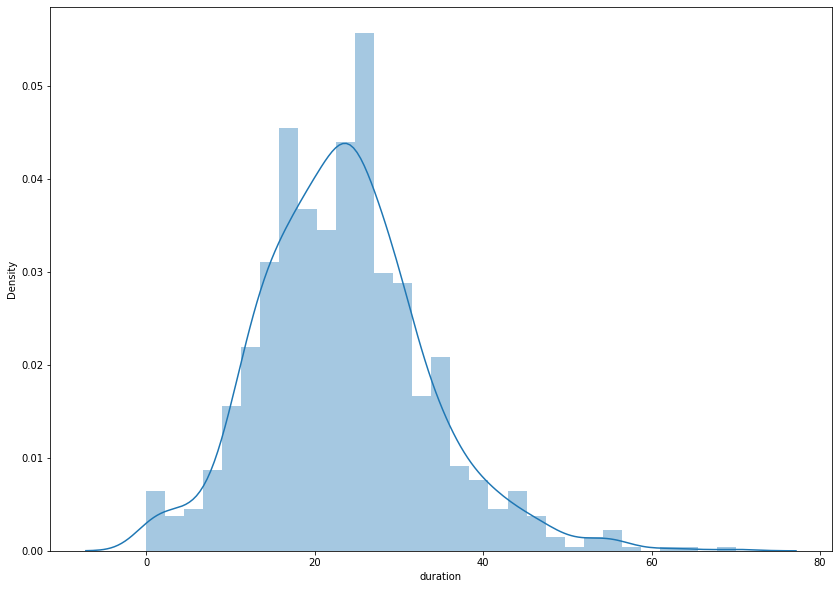

In [11]:
sns.distplot(df.duration)

<AxesSubplot:xlabel='duration'>

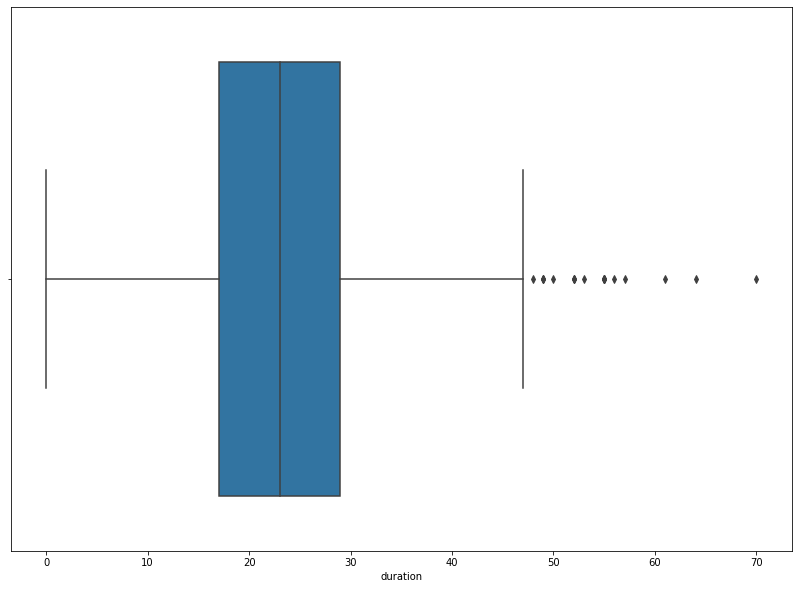

In [12]:
sns.boxplot(df.duration)

In [13]:
# Valores únicos de la variable "civ".
civs = df.civ.unique().tolist()
civs.sort()
# Creación de la función personalizada "obtener los índices de frecuencia por país".
def get_frequency_rates_by_civ(df):
    return pd.DataFrame(df.civ.value_counts(normalize=True)).reset_index().rename(columns={"index": "civ", "civ": "frequency"})
# Creación de la función personalizada "obtener las tasas de victoria por país".
def get_win_rates_by_civ(df):
    return (
        df.groupby("civ")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )
# Aplicación de las dos funciones creadas anteriormente.
frequency_rates_civ = get_frequency_rates_by_civ(df)
win_rates_civ              = get_win_rates_by_civ(df)

Text(0.5, 1.0, 'Frecuencia de partidas por civilización')

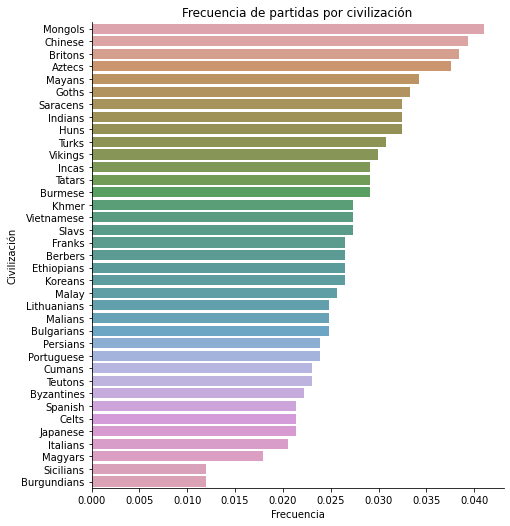

In [14]:
sns.catplot(y="civ",
                        x="frequency", 
                        data=frequency_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h",
                        order=frequency_rates_civ.sort_values('frequency', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Frecuencia")
plt.title("Frecuencia de partidas por civilización")

Text(0.5, 1.0, 'Tasa de victorias por civilización')

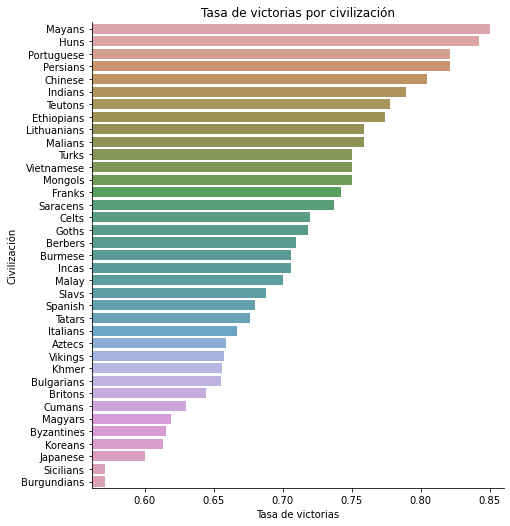

In [15]:
sns.catplot(y="civ",
                        x="win_rate", 
                        data=win_rates_civ,
                        saturation=0.5,
                        kind="bar",
                        ci=None,
                        aspect=1,
                        height=7,
                        orient="h", 
                        order=win_rates_civ.sort_values('win_rate', ascending=False).civ)
plt.ylabel("Civilización")
plt.xlabel("Tasa de victorias")
lim_sup = float(win_rates_civ.win_rate.head(1) + 0.01)
lim_inf = float(win_rates_civ.win_rate.tail(1) - 0.01)
plt.xlim(lim_inf, lim_sup)
plt.title("Tasa de victorias por civilización")

In [16]:
# Función para la creación de variables dummy.
def create_dummies(df, var_name):
    dummy = pd.get_dummies(df[var_name], prefix=var_name)
    df = df.drop(var_name, axis = 1)
    df = pd.concat([df, dummy ], axis = 1)
    return df
# Creación variables dummy.
categorical = ["civ"]
for category in categorical:
    df = create_dummies(df, category)

In [17]:
# Transformación de las entidades escalando cada entidad a un rango determinado.
scaler = MinMaxScaler() 
arr_scaled = scaler.fit_transform(df) 
df_scaled = pd.DataFrame(arr_scaled, columns=df.columns,index=df.index)
df_scaled

,duration,won,civ_Aztecs,civ_Berbers,civ_Britons,civ_Bulgarians,civ_Burgundians,civ_Burmese,civ_Byzantines,civ_Celts,...,civ_Portuguese,civ_Saracens,civ_Sicilians,civ_Slavs,civ_Spanish,civ_Tatars,civ_Teutons,civ_Turks,civ_Vietnamese,civ_Vikings
0,0.285714,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.142857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.442857,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.400000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.114286,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,0.371429,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1166,0.157143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1167,0.271429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1168,0.385714,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Selección de rasgos para el modelo.
features = len(df_scaled.columns.values)
summary_models_logreg = pd.DataFrame(columns=['initial_features', 
                                                                                                       'final_features',
                                                                                                       'aic',
                                                                                                       'bic',
                                                                                                       'df_residuals',
                                                                                                       'r_squared',
                                                                                                       'score_accuracy',
                                                                                                       'roc_auc_score'])
for f in range(4, features, 4):
    print("-------------")
    print("Features:", f)
    # Recursive Feature Elimination
    df_vars=df_scaled.columns.values.tolist()
    y_var=['won']
    X_var=[i for i in df_vars if i not in y_var]
    y = pd.DataFrame(data=df_scaled,columns=y_var)
    X = pd.DataFrame(data=df_scaled,columns=X_var)
    logreg_sklearn = LogisticRegression()
    rfe = RFE(logreg_sklearn, f)
    try:
        rfe = rfe.fit(X, y.values.ravel())
        cols = []
        for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
            if selected == True:
                cols.append(var)
        X=df_scaled[cols]
        y=df_scaled['won']

        # Implementing the model
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Remove unsignificant variables
        pvalues = list(logreg_sm_results.pvalues)
        cols_s = pd.DataFrame(list(zip(cols, pvalues)))
        cols_s.columns = ["variable", "pvalue"]
        cols_s = cols_s[cols_s["pvalue"] <= 0.05]
        cols_s.reset_index(inplace=True, drop=True)
        cols_s = list(cols_s["variable"])
        X=df_scaled[cols_s]
        y=df_scaled['won']
        logreg_sm=sm.Logit(y,X)
        logreg_sm_results=logreg_sm.fit()

        # Logistic Regression Model Fitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        logreg_sklearn = LogisticRegression()
        logreg_sklearn.fit(X_train, y_train)
        from sklearn.metrics import roc_auc_score
        logreg_sklearn_roc_auc = roc_auc_score(y_test, logreg_sklearn.predict(X_test))

        # Final features.
        final_features = len(logreg_sm_results.params)
        # Akaike’s information criteria.
        aic = round(logreg_sm_results.aic, 4)
        # Bayes’ information criteria.
        bic = round(logreg_sm_results.bic, 4)
        # Residual degrees of freedom.
        df_resid = int(logreg_sm_results.df_resid)
        # R squared.
        rsquared = round(logreg_sm_results.prsquared, 4)
        # Score of logreg_sklearn.
        score_accuracy = round(logreg_sklearn.score(X_test, y_test), 4)
        # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
        roc_auc_score = round(logreg_sklearn_roc_auc, 4)

        # Append to final dataframe summary of logistic regression.
        data_to_append = [f, final_features, aic, bic, df_resid, rsquared, score_accuracy, roc_auc_score]
        a_series = pd.Series(data_to_append, index=summary_models_logreg.columns)
        summary_models_logreg = summary_models_logreg.append(a_series, ignore_index=True)
    except:
        pass

-------------
Features: 4
Optimization terminated successfully.
         Current function value: 0.632270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633996
         Iterations 6
-------------
Features: 8
Optimization terminated successfully.
         Current function value: 0.627791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629846
         Iterations 6
-------------
Features: 12
Optimization terminated successfully.
         Current function value: 0.624654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626858
         Iterations 6
-------------
Features: 16
Optimization terminated successfully.
         Current function value: 0.624342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626858
         Iterations 6
-------------
Features: 20
Optimization terminated successfully.
         Curr

In [19]:
summary_models_logreg = summary_models_logreg[summary_models_logreg["r_squared"]>0]
summary_models_logreg = summary_models_logreg.sort_values(by=['score_accuracy', 'roc_auc_score', 'r_squared'], ascending=[False, False, False]).reset_index(drop=True)
summary_models_logreg.head(10)

,initial_features,final_features,aic,bic,df_residuals,r_squared,score_accuracy,roc_auc_score
0,36.0,34.0,1435.852,1608.0538,1136.0,0.02,0.7123,0.5022


In [20]:
f = int(summary_models_logreg.initial_features[0])
# Recursive Feature Elimination
df_vars=df_scaled.columns.values.tolist()
y_var=['won']
X_var=[i for i in df_vars if i not in y_var]
y = pd.DataFrame(data=df_scaled,columns=y_var)
X = pd.DataFrame(data=df_scaled,columns=X_var)
logreg_sklearn = LogisticRegression()
rfe = RFE(logreg_sklearn, f)
rfe = rfe.fit(X, y.values.ravel())
cols = []
for var, selected, rank in zip(X_var, rfe.support_, rfe.ranking_):
    if selected == True:
        cols.append(var)
X=df_scaled[cols]
y=df_scaled['won']

# Implementing the model
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

# Remove unsignificant variables
pvalues = list(logreg_sm_results.pvalues)
cols_s = pd.DataFrame(list(zip(cols, pvalues)))
cols_s.columns = ["variable", "pvalue"]
cols_s = cols_s[cols_s["pvalue"] <= 0.05]
cols_s.reset_index(inplace=True, drop=True)
cols_s = list(cols_s["variable"])
X=df_scaled[cols_s]
y=df_scaled['won']
logreg_sm=sm.Logit(y,X)
logreg_sm_results=logreg_sm.fit()

Optimization terminated successfully.
         Current function value: 0.582658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.584552
         Iterations 6


In [21]:
logreg_sm_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.020    
Dependent Variable: won              AIC:              1435.8520
Date:               2021-07-05 18:48 BIC:              1608.0538
No. Observations:   1170             Log-Likelihood:   -683.93  
Df Model:           33               LL-Null:          -697.87  
Df Residuals:       1136             LLR p-value:      0.71962  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
duration         -1.3382   0.3771 -3.5484 0.0004 -2.0773 -0.5990
civ_Aztecs        1.0934   0.3419  3.1984 0.0014  0.4234  1.7634
civ_Berbers       1.4002   0.4244  3.2994 0.0010  0.5685  2.2320
civ_Britons       1.1012   0.3441  3.2005 0.0014  0.4269  1.7756
civ_Bulgarians    1.0818   0.4125  2.6227 0.0087  0.2734  1.8903
civ_Byzantines    0.9280   0.4262  2.1776 0.0294  0.0928  1.7633
civ_Celts         1.2880   0.4573  2.8167 0.0049  0.3918  2.1842
civ_Chinese       1.8394   0.3916  4.6968 0.0000  1.0718  2.6069
civ_Cumans        0.9993   0.4215  2.3707 0.0178  0.1732  1.8255
civ_Ethiopians    1.6806   0.4507  3.7285 0.0002  0.7972  2.5640
civ_Franks        1.5293   0.4331  3.5308 0.0004  0.6804  2.3782
civ_Huns          2.0358   0.4573  4.4521 0.0000  1.1396  2.9321
civ_Incas         1.2836   0.3945  3.2533 0.0011  0.5103  2.0569
civ_Indians       1.7572   0.4181  4.2031 0.0000  0.9378  2.5766
civ_Italians      1.1969   0.4585  2.6103 0.0090  0.2982  2.0955
civ_Japanese      0.8911   0.4332  2.0571 0.0397  0.0421  1.7401
civ_Khmer         1.0960   0.3940  2.7817 0.0054  0.3238  1.8683
civ_Koreans       0.9951   0.4008  2.4829 0.0130  0.2096  1.7805
civ_Lithuanians   1.6192   0.4558  3.5525 0.0004  0.7259  2.5126
civ_Magyars       0.8775   0.4640  1.8913 0.0586 -0.0319  1.7869
civ_Malay         1.3748   0.4279  3.2130 0.0013  0.5361  2.2134
civ_Malians       1.6027   0.4544  3.5270 0.0004  0.7121  2.4933
civ_Mayans        2.1846   0.4634  4.7146 0.0000  1.2764  3.0928
civ_Mongols       1.5358   0.3574  4.2976 0.0000  0.8354  2.2362
civ_Persians      2.0168   0.5136  3.9271 0.0001  1.0103  3.0234
civ_Portuguese    1.9650   0.5115  3.8419 0.0001  0.9625  2.9674
civ_Saracens      1.4931   0.3927  3.8023 0.0001  0.7234  2.2627
civ_Slavs         1.2682   0.4065  3.1198 0.0018  0.4715  2.0650
civ_Spanish       1.2454   0.4539  2.7435 0.0061  0.3557  2.1351
civ_Tatars        1.1888   0.3891  3.0549 0.0023  0.4261  1.9515
civ_Teutons       1.6876   0.4808  3.5103 0.0004  0.7454  2.6299
civ_Turks         1.5974   0.4132  3.8659 0.0001  0.7875  2.4072
civ_Vietnamese    1.5360   0.4278  3.5901 0.0003  0.6974  2.3745
civ_Vikings       1.0960   0.3787  2.8938 0.0038  0.3537  1.8383
================================================================

"""

In [22]:
coefficients = dict(logreg_sm_results.params)
coefficients = pd.DataFrame.from_dict(coefficients, orient='index').reset_index(level=0)
coefficients.columns = ['Variable', 'Coeficiente']
coefficients

,Variable,Coeficiente
0,duration,-1.338169
1,civ_Aztecs,1.093370
2,civ_Berbers,1.400248
3,civ_Britons,1.101245
4,civ_Bulgarians,1.081849
5,civ_Byzantines,0.928024
6,civ_Celts,1.287999
7,civ_Chinese,1.839359
8,civ_Cumans,0.999343
9,civ_Ethiopians,1.680597


In [23]:
for index, row in coefficients.iterrows():
    print("Si la variable " + row["Variable"] + " incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en " + str(round(row["Coeficiente"], 3)))

Si la variable duration incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en -1.338
Si la variable civ_Aztecs incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 1.093
Si la variable civ_Berbers incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 1.4
Si la variable civ_Britons incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 1.101
Si la variable civ_Bulgarians incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 1.082
Si la variable civ_Byzantines incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 0.928
Si la variable civ_Celts incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 1.288
Si la variable civ_Chinese incrementa en una unidad, el cociente de probabilidades de victoria se incrementará en 1.839
Si la variable civ_Cumans incrementa en u

In [24]:
corr = X.corr().abs()
corr = corr[corr > 0.7]
corr

,duration,civ_Aztecs,civ_Berbers,civ_Britons,civ_Bulgarians,civ_Byzantines,civ_Celts,civ_Chinese,civ_Cumans,civ_Ethiopians,...,civ_Persians,civ_Portuguese,civ_Saracens,civ_Slavs,civ_Spanish,civ_Tatars,civ_Teutons,civ_Turks,civ_Vietnamese,civ_Vikings
duration,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Aztecs,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Berbers,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Britons,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Bulgarians,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Byzantines,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Celts,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Chinese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Cumans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
civ_Ethiopians,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


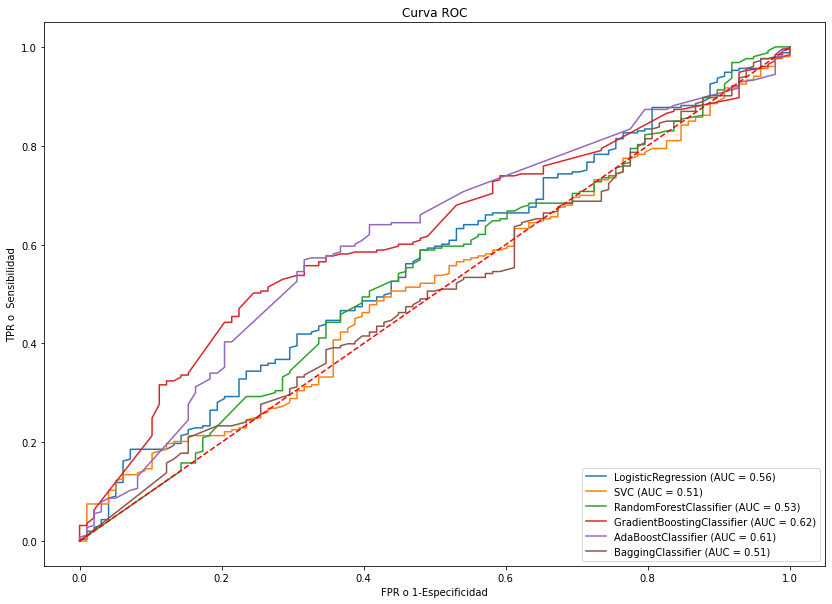

In [25]:
from sklearn.metrics import plot_roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
ax=plt.gca()
# LogisticRegression
logreg_sklearn = LogisticRegression()
logreg_sklearn.fit(X_train, y_train)
logreg_sklearn_roc = plot_roc_curve(logreg_sklearn, X_test, y_test, ax=ax)
# SVC (Support Vector Classification)
svc_sklearn = SVC(random_state=2021)
svc_sklearn.fit(X_train, y_train)
svc_sklearn_roc = plot_roc_curve(svc_sklearn, X_test, y_test, ax=ax)
# RandomForestClassifier
rfc_sklearn = RandomForestClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
rfc_sklearn.fit(X_train, y_train)
rfc_sklearn_roc = plot_roc_curve(rfc_sklearn, X_test, y_test, ax=ax)
# GradientBoostingClassifier
gbc_sklearn = GradientBoostingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
gbc_sklearn.fit(X_train, y_train)
gbc_sklearn_roc = plot_roc_curve(gbc_sklearn, X_test, y_test, ax=ax)
# AdaBoostClassifier
abc_sklearn = AdaBoostClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
abc_sklearn.fit(X_train, y_train)
abc_sklearn_roc = plot_roc_curve(abc_sklearn, X_test, y_test, ax=ax)
# BaggingClassifier
bgc_sklearn =BaggingClassifier(n_estimators=int(logreg_sm_results.df_model), random_state=2021)
bgc_sklearn.fit(X_train, y_train)
bgc_sklearn_roc = plot_roc_curve(bgc_sklearn, X_test, y_test, ax=ax)

plt.title("Curva ROC")
plt.ylabel("TPR o  Sensibilidad")
plt.xlabel("FPR o 1-Especificidad")
plt.plot([0, 1], [0, 1],'r--')
rcParams['figure.figsize'] = 16, 10
# plt.rcParams["figure.figsize"] = (12, 12)
plt.show()

In [26]:
# Scores.
score_lr     = round(logreg_sklearn.score(X_test, y_test), 5)
score_svc = round(svc_sklearn.score(X_test, y_test), 5)
score_rfc  = round(rfc_sklearn.score(X_test, y_test), 5)
score_gbc = round(gbc_sklearn.score(X_test, y_test), 5)
score_abc = round(abc_sklearn.score(X_test, y_test), 5)
score_bgc = round(bgc_sklearn.score(X_test, y_test), 5)
# Asignar datos de la lista.  
results = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score': [score_lr, score_svc, score_rfc, score_gbc, score_abc, score_bgc]}  
# Crear DataFrame .
df_results = pd.DataFrame(results)  
# Imprimir listado de Scores.  
df_results.sort_values(by=['Score'], ascending=False, ignore_index=True)

,Model,Score
0,SVC (SupportVectorClassifier),0.72080
1,LogisticRegression,0.70940
2,GradientBoostingClassifier,0.70085
3,AdaBoostClassifier,0.67806
4,RandomForestClassifier,0.62393
5,BaggingClassifier,0.61823


In [27]:
# Scores CV.
score_lr_cv     = round(cross_val_score(logreg_sklearn, X, y, cv=10).mean(), 5)
score_svc_cv = round(cross_val_score(svc_sklearn, X, y, cv=10).mean(), 5)
score_rfc_cv  = round(cross_val_score(rfc_sklearn, X, y, cv=10).mean(), 5)
score_gbc_cv = round(cross_val_score(gbc_sklearn, X, y, cv=10).mean(), 5)
score_abc_cv = round(cross_val_score(abc_sklearn, X, y, cv=10).mean(), 5)
score_bgc_cv = round(cross_val_score(bgc_sklearn, X, y, cv=10).mean(), 5)
# Asignar datos de la lista.   
results_cv = {'Model': ['LogisticRegression', 'SVC (SupportVectorClassifier)', 'RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'BaggingClassifier'],
               'Score CV 10': [score_lr_cv, score_svc_cv, score_rfc_cv, score_gbc_cv, score_abc_cv, score_bgc_cv]}  
# Crear DataFrame .
df_results_cv = pd.DataFrame(results_cv)  
# Imprimir listado de Scores CV.  
df_results_cv.sort_values(by=['Score CV 10'], ascending=False, ignore_index=True)

,Model,Score CV 10
0,SVC (SupportVectorClassifier),0.71624
1,LogisticRegression,0.70855
2,GradientBoostingClassifier,0.68974
3,AdaBoostClassifier,0.67778
4,RandomForestClassifier,0.62906
5,BaggingClassifier,0.60855
